In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters
import skimage.segmentation
import skimage.measure
import glob
import random

# Image show

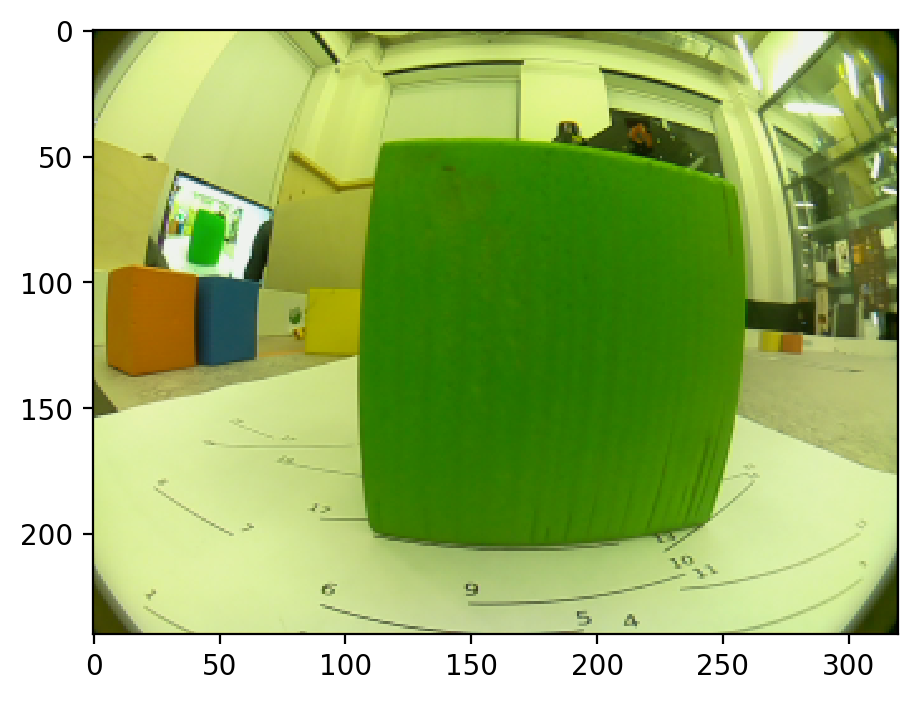

In [262]:
raw_img = cv2.cvtColor(cv2.imread("imgs/1_15.png"), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(raw_img);

# Undistorte image

In [263]:
K=np.array([[543.107811968841, 0.0, 630.7227631662455], [0.0, 540.0320855865099, 486.5749791589516], [0.0, 0.0, 1.0]])
D=np.array([[-0.05195582161040964], [-0.009477421485536482], [0.010893416415594874], [-0.005379345567357744]])
K1 = K.copy()
K1[:2] /= 4
K2 = K1.copy()
K2[:2, :2] /= 2

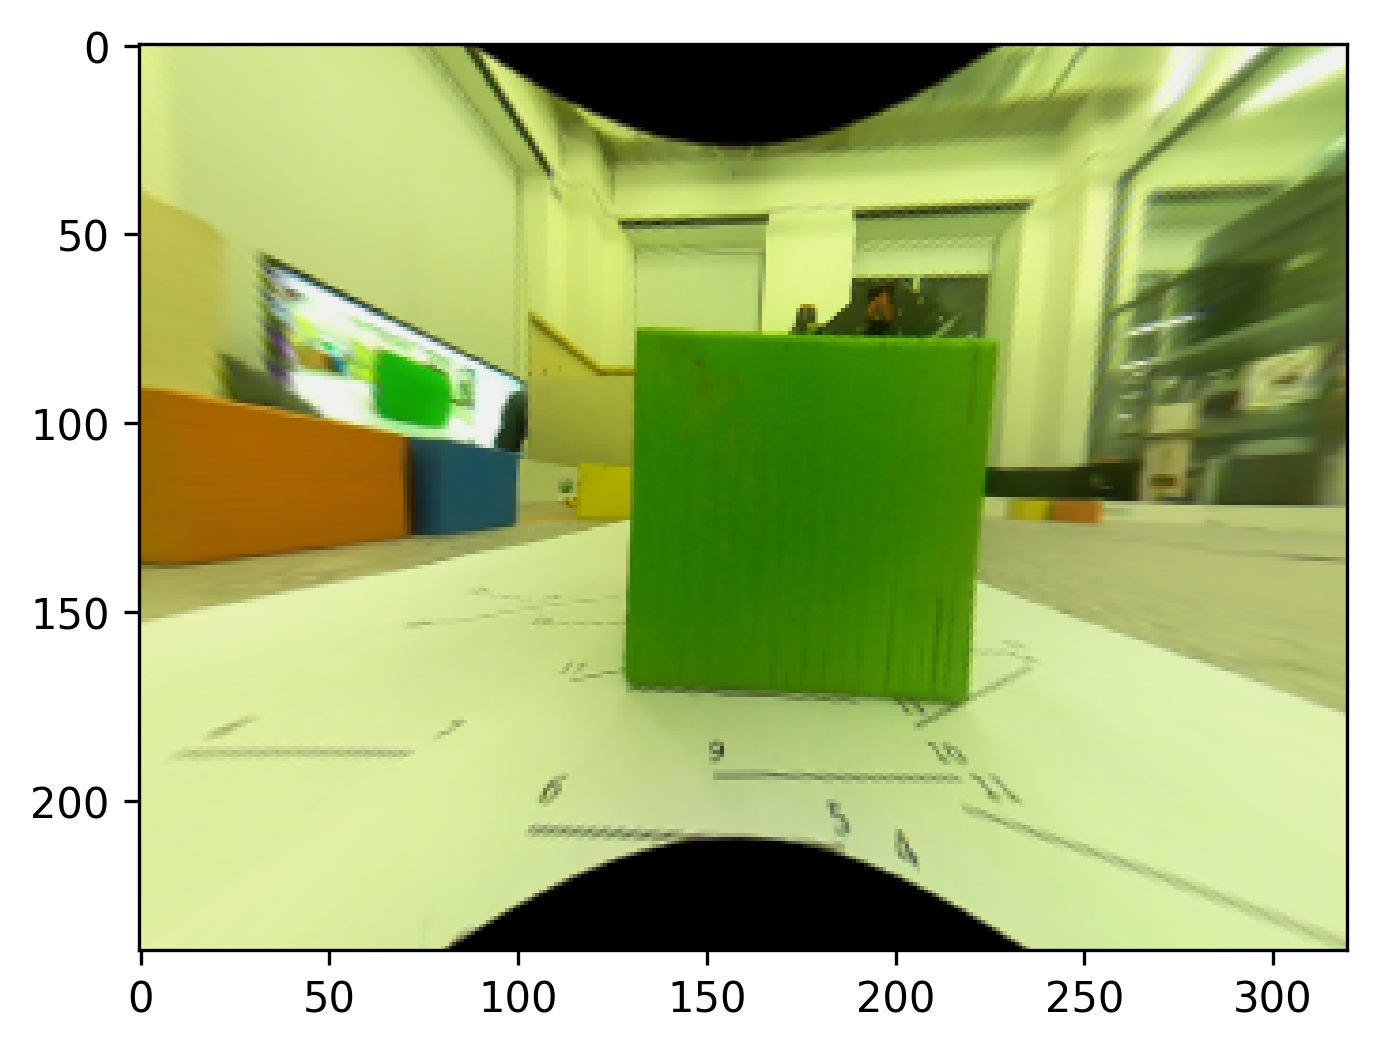

In [264]:
undisort_img = cv2.fisheye.undistortImage(raw_img, K1, D, Knew = K2)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(undisort_img);

# Smoothing

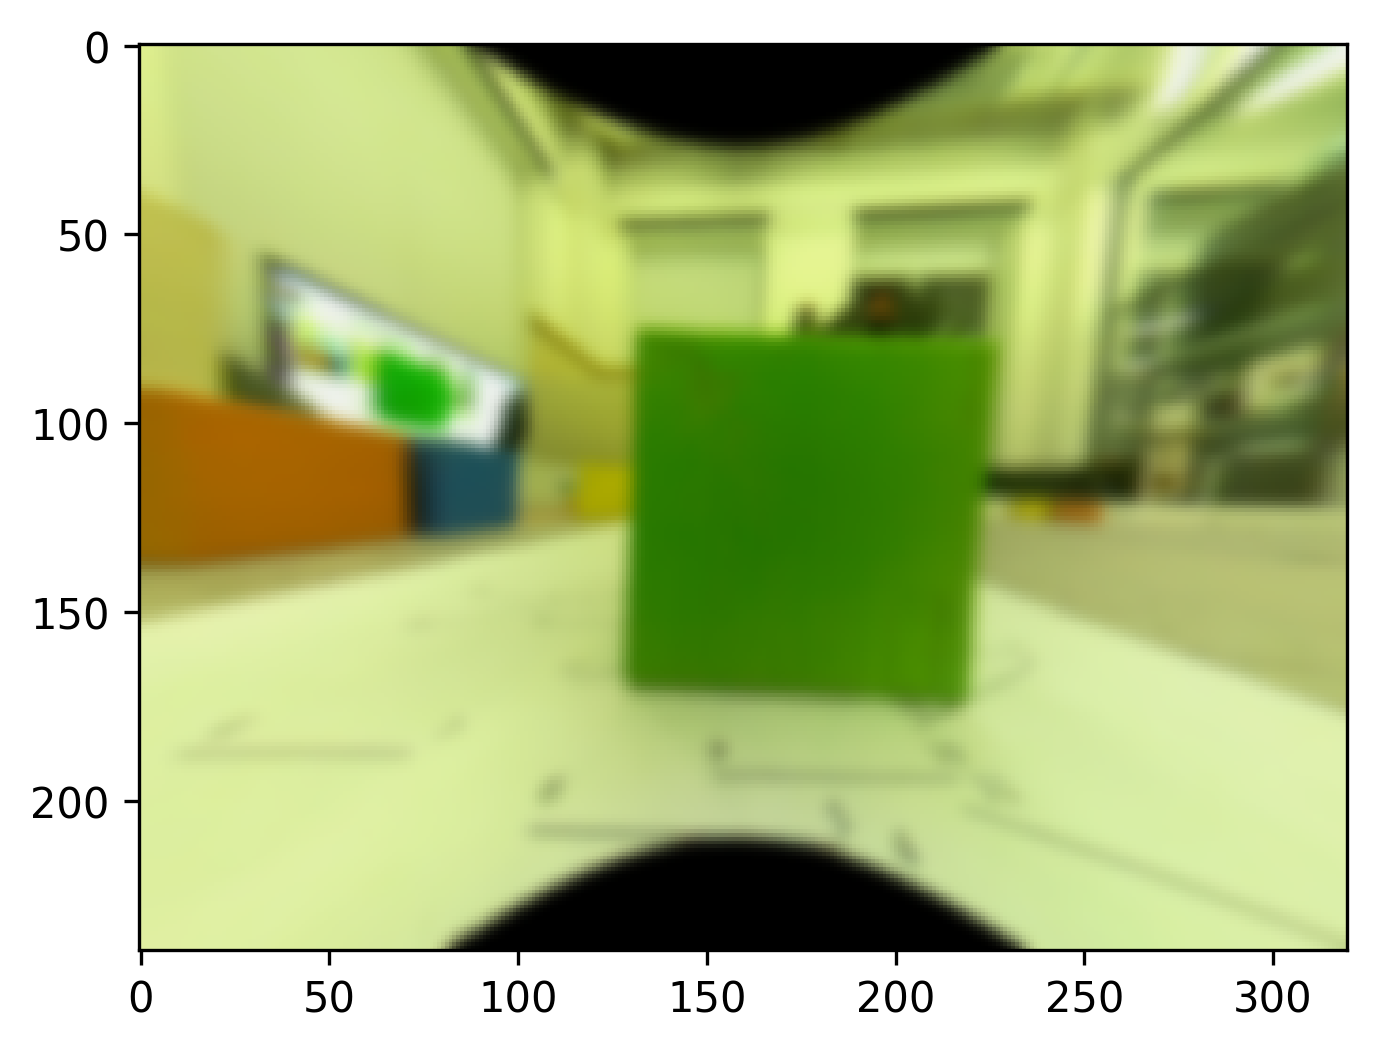

In [265]:
smooth_img = np.zeros_like(undisort_img, dtype=np.float32)
for c in range(3):
    smooth_img[:, :, c] = skimage.filters.gaussian(undisort_img[:, :, c], sigma=2)
smooth_img = (255 * smooth_img).astype(np.uint8)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(smooth_img);

# Segmentation

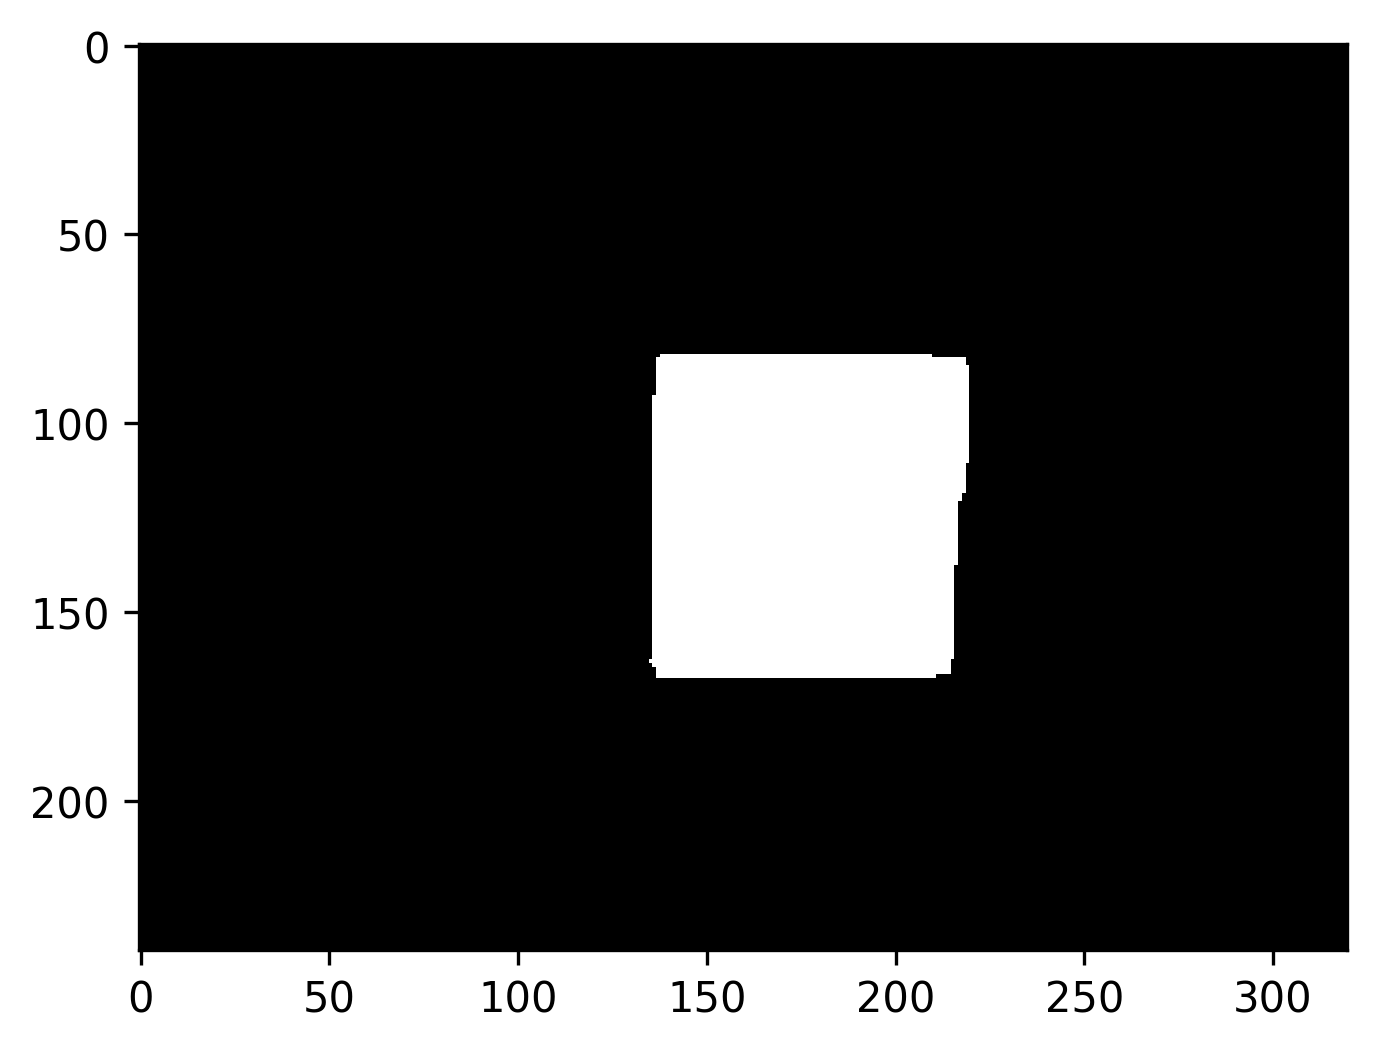

In [289]:
segments = skimage.segmentation.felzenszwalb(undisort_img, scale=120, sigma=3, min_size=30)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(segments==segments[150, 150], cmap="gray");

In [290]:
def get_params(labels):
    h, w = labels.shape[0:2]
    x = np.arange(w)
    y = np.arange(h)
    m = np.count_nonzero(labels)
    xc = np.sum(x[np.newaxis, :] * (labels)) / m
    yc = np.sum(y[:, np.newaxis] * (labels)) / m
    return int(m ** 0.5), int(xc), int(yc)
side, xc, yc = get_params(segments==segments[150, 150])

# Many images

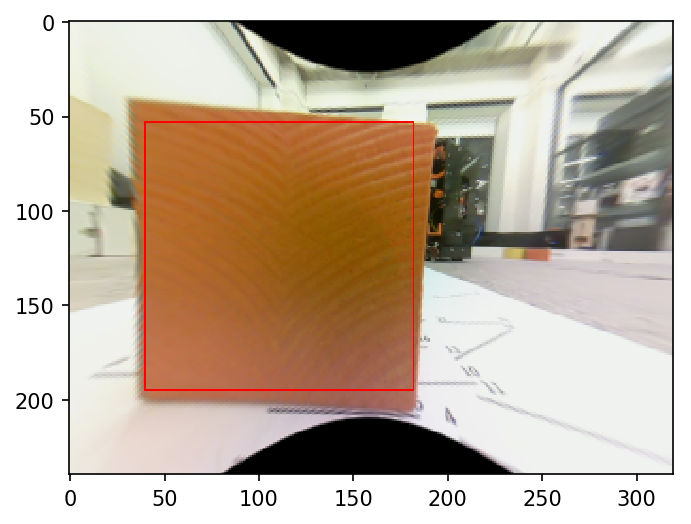

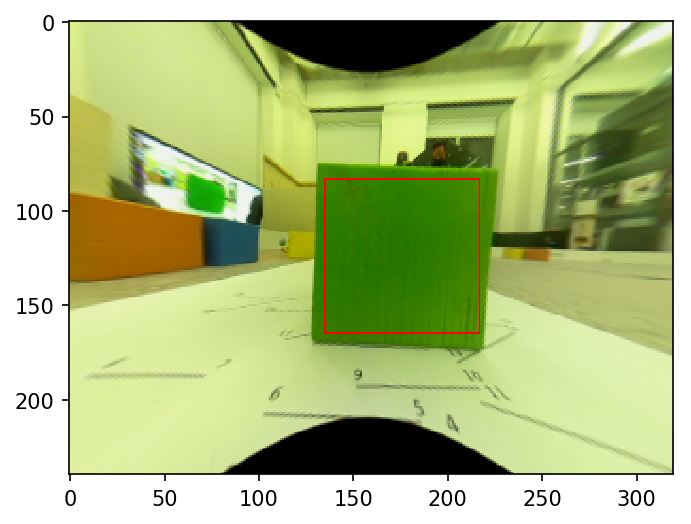

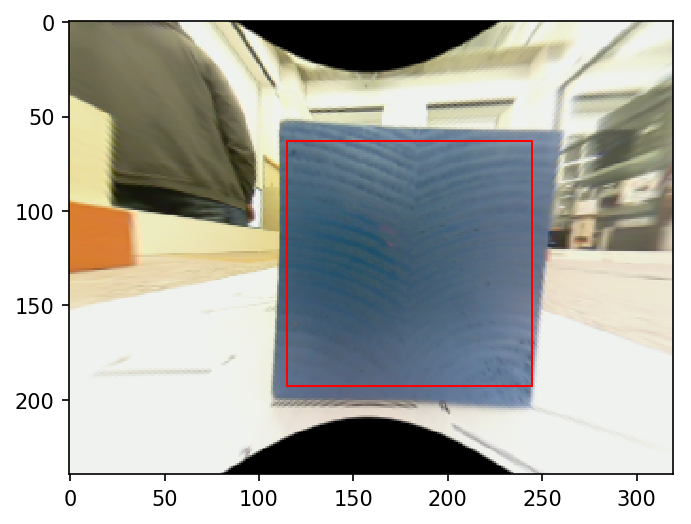

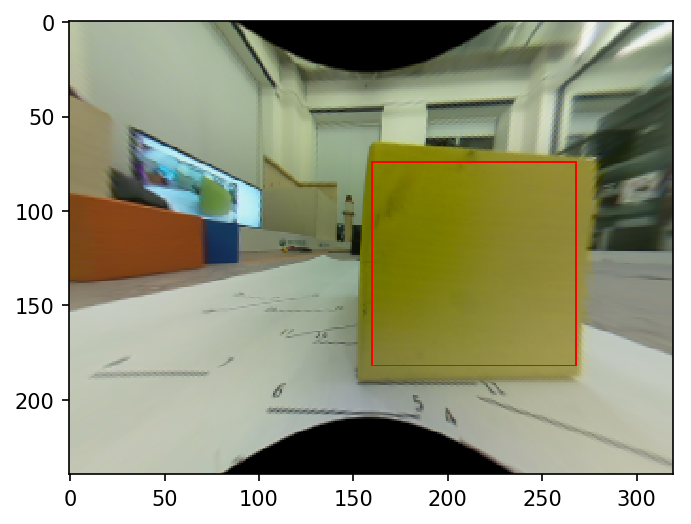

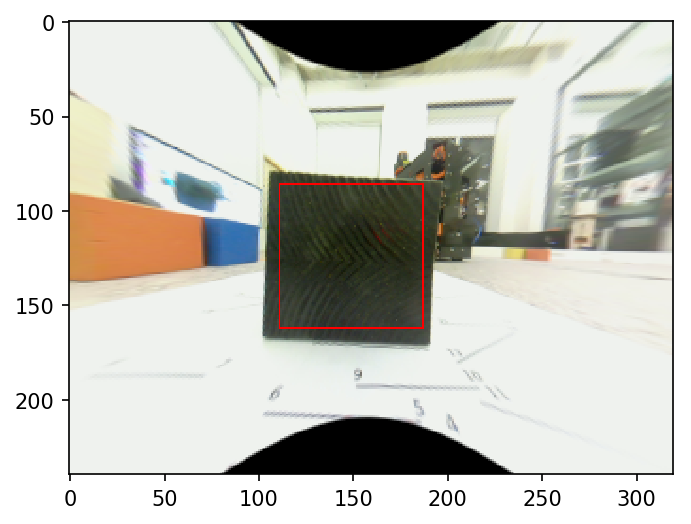

In [37]:
files = glob.glob("imgs/*.png")
center = (160, 120)
for file in files:
    img1 = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    img2 = cv2.fisheye.undistortImage(img1, K1, D, Knew = K2)
    
    labels = skimage.segmentation.felzenszwalb(img2, scale=120, sigma=3, min_size=30)
    side, xc, yc = get_params(labels==labels[center[1], center[0]])
    
    cv2.rectangle(img2, (xc + side//2, yc + side // 2), (xc - side//2, yc - side//2), (255, 0, 0))
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
    plt.imshow(img2, cmap="gray");

# Optimization

In [297]:
ALPHA = 200.
def cost_func(img, params):
    mask = np.zeros_like(img)
    mask[params[0]:params[1], params[2]:params[3]] = 1
    N = np.count_nonzero(mask[:, :, 0])
    print(N)
    var = np.std(img[params[0]:params[1], params[2]:params[3]], axis=(0, 1))
    print(var)
#     print(var)
    return N / ALPHA - np.sum(var) 

In [298]:
init_params = np.array((yc - side//2, yc + side // 2, xc - side//2, xc + side//2))
print(init_params)
cost_func(undisort_img, init_params)

[ 83 165 135 217]
6724
[9.28272556 5.86701464 0.66907518]


17.80118461838139

In [299]:
input_img = undisort_img.copy()
diff_ind = np.array([[1, -1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, -1, 0, 0, 0, 0, 0], 
                     [0, 0, 0, 0, 1, -1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, -1, 0]])
params = init_params
for i in range(100):
    costs = np.zeros(9)
    for j in range(9):
        costs[j] = cost_func(input_img, params + diff_ind[:, j])
    params = params + diff_ind[:, np.argmax(costs)]

6642
[9.29401208 5.82130967 0.67315268]
6806
[9.26890483 5.90773251 0.66507089]
6806
[9.3571152  5.91854569 0.69064836]
6642
[9.21168252 5.82022706 0.61872367]
6642
[9.30033272 5.8879221  0.67315268]
6806
[9.26264443 5.84929891 0.66507089]
6806
[9.53520954 5.98572103 0.79812332]
6642
[9.05604334 5.76718889 0.54139266]
6724
[9.28272556 5.86701464 0.66907518]
6723
[9.27351717 5.80258773 0.66912446]
6889
[9.24940047 5.89072535 0.66109009]
6889
[9.33691593 5.90020174 0.68651798]
6723
[9.19167239 5.80312158 0.61501764]
6724
[9.28272556 5.86701464 0.66907518]
6888
[9.24310905 5.82558109 0.66113763]
6888
[9.5139076  5.96730481 0.7934189 ]
6724
[9.03708073 5.75006933 0.53810527]
6806
[9.26264443 5.84929891 0.66507089]
6804
[9.25278345 5.77849961 0.6651677 ]
6972
[9.23086226 5.86757542 0.65717993]
6972
[9.31754644 5.87598885 0.68246082]
6804
[9.17222394 5.77988299 0.61137741]
6806
[9.26264443 5.84929891 0.66507089]
6970
[9.22236915 5.79465225 0.65727334]
6970
[9.49288084 5.94305919 0.78879667]


[9.39669154 6.12903556 0.75632324]
7650
[9.60538507 6.23743828 0.88501116]
7565
[9.59574986 6.16900653 0.88988147]
7735
[9.78330712 6.54373493 0.88169743]
7735
[9.76171982 6.41268171 1.99398109]
7565
[9.52620281 6.14205569 0.81052675]
7560
[9.62403785 6.26454463 0.8865888 ]
7740
[9.84316913 6.26995327 1.24577325]
7740
[9.83762066 6.36401249 1.01327753]
7560
[9.39669154 6.12903556 0.75632324]
7650
[9.60538507 6.23743828 0.88501116]
7565
[9.59574986 6.16900653 0.88988147]
7735
[9.78330712 6.54373493 0.88169743]
7735
[9.76171982 6.41268171 1.99398109]
7565
[9.52620281 6.14205569 0.81052675]
7560
[9.62403785 6.26454463 0.8865888 ]
7740
[9.84316913 6.26995327 1.24577325]
7740
[9.83762066 6.36401249 1.01327753]
7560
[9.39669154 6.12903556 0.75632324]
7650
[9.60538507 6.23743828 0.88501116]
7565
[9.59574986 6.16900653 0.88988147]
7735
[9.78330712 6.54373493 0.88169743]
7735
[9.76171982 6.41268171 1.99398109]
7565
[9.52620281 6.14205569 0.81052675]
7560
[9.62403785 6.26454463 0.8865888 ]
7740


[9.62403785 6.26454463 0.8865888 ]
7740
[9.84316913 6.26995327 1.24577325]
7740
[9.83762066 6.36401249 1.01327753]
7560
[9.39669154 6.12903556 0.75632324]
7650
[9.60538507 6.23743828 0.88501116]
7565
[9.59574986 6.16900653 0.88988147]
7735
[9.78330712 6.54373493 0.88169743]
7735
[9.76171982 6.41268171 1.99398109]
7565
[9.52620281 6.14205569 0.81052675]
7560
[9.62403785 6.26454463 0.8865888 ]
7740
[9.84316913 6.26995327 1.24577325]
7740
[9.83762066 6.36401249 1.01327753]
7560
[9.39669154 6.12903556 0.75632324]
7650
[9.60538507 6.23743828 0.88501116]
7565
[9.59574986 6.16900653 0.88988147]
7735
[9.78330712 6.54373493 0.88169743]
7735
[9.76171982 6.41268171 1.99398109]
7565
[9.52620281 6.14205569 0.81052675]
7560
[9.62403785 6.26454463 0.8865888 ]
7740
[9.84316913 6.26995327 1.24577325]
7740
[9.83762066 6.36401249 1.01327753]
7560
[9.39669154 6.12903556 0.75632324]
7650
[9.60538507 6.23743828 0.88501116]
7565
[9.59574986 6.16900653 0.88988147]
7735
[9.78330712 6.54373493 0.88169743]
7735


[9.84316913 6.26995327 1.24577325]
7740
[9.83762066 6.36401249 1.01327753]
7560
[9.39669154 6.12903556 0.75632324]
7650
[9.60538507 6.23743828 0.88501116]
7565
[9.59574986 6.16900653 0.88988147]
7735
[9.78330712 6.54373493 0.88169743]
7735
[9.76171982 6.41268171 1.99398109]
7565
[9.52620281 6.14205569 0.81052675]
7560
[9.62403785 6.26454463 0.8865888 ]
7740
[9.84316913 6.26995327 1.24577325]
7740
[9.83762066 6.36401249 1.01327753]
7560
[9.39669154 6.12903556 0.75632324]
7650
[9.60538507 6.23743828 0.88501116]
7565
[9.59574986 6.16900653 0.88988147]
7735
[9.78330712 6.54373493 0.88169743]
7735
[9.76171982 6.41268171 1.99398109]
7565
[9.52620281 6.14205569 0.81052675]
7560
[9.62403785 6.26454463 0.8865888 ]
7740
[9.84316913 6.26995327 1.24577325]
7740
[9.83762066 6.36401249 1.01327753]
7560
[9.39669154 6.12903556 0.75632324]
7650
[9.60538507 6.23743828 0.88501116]
7565
[9.59574986 6.16900653 0.88988147]
7735
[9.78330712 6.54373493 0.88169743]
7735
[9.76171982 6.41268171 1.99398109]
7565


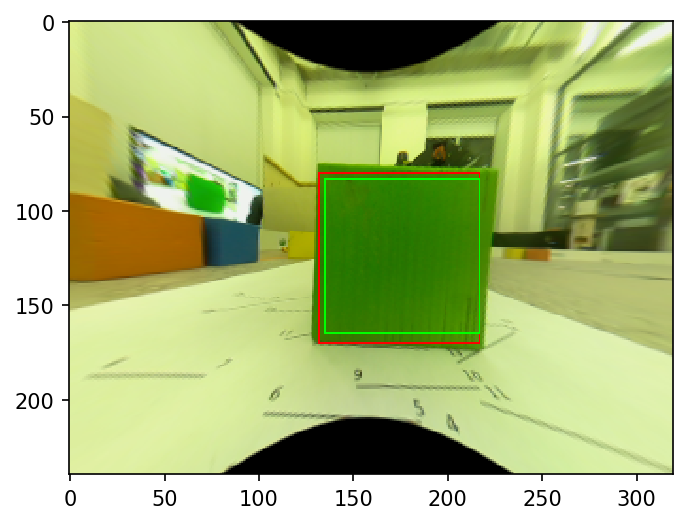

In [300]:
cv2.rectangle(input_img, (params[3], params[1]), (params[2], params[0]), (255, 0, 0))
cv2.rectangle(input_img, (init_params[3], init_params[1]), (init_params[2], init_params[0]), (0, 255, 0))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
plt.imshow(input_img, cmap="gray");

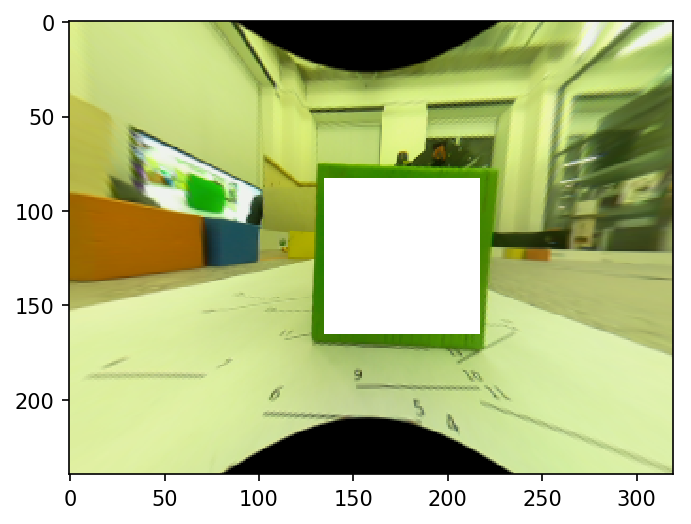

In [310]:
p = init_params.copy()
input_img = undisort_img.copy()
points = np.array([p[3], p[2], p[2], p[3], p[0], p[0], p[1], p[1]])
cv2.fillPoly(input_img, points.reshape((2, 4)). T[np.newaxis, :, :], (255, 255, 255))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
plt.imshow(input_img, cmap="gray");

In [302]:
def new_cost_func(img, params):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, params.reshape((2, 4)).T[np.newaxis, :, :], (1, 1, 1))
    N = np.count_nonzero(mask[:, :, 0])
#     print(N)
    mean = 1. * np.sum(mask * img, axis=(0, 1)) / N
    var = np.sqrt(1. * np.sum(mask * (img - mean) ** 2, axis=(0, 1)) / N)
    print(var)
#     print(var)
    print(N)
    return N / ALPHA - np.sum(var)

def get_new_neighbor(params):
    ind = np.random.randint(len(params))
    diff = np.random.randint(13) - 3
    params = params.copy()
    params[ind] += diff
    return params

In [311]:
def local_search(img, init_params):
    params = init_params
    cost = new_cost_func(img, params)
    for i in range(200):
        new_params = get_new_neighbor(params)
        new_cost = new_cost_func(img, new_params)
        if new_cost > cost:
            params = new_params
            cost = new_cost
    return params

opt_params = local_search(undisort_img, points)

[9.60808998 6.04045513 0.82319977]
6889
[9.61133425 6.07983921 0.82079409]
6930
[9.61133425 6.07983921 0.82079409]
6930
[9.57592734 6.03663692 0.81358781]
7055
[20.31917332 13.14512035 16.02246279]
7391
[9.7281733  6.01035986 0.8365414 ]
6668
[9.54530027 6.00461432 0.8065126 ]
7181
[9.637693   6.09416222 0.82067728]
6932
[9.54530027 6.00461432 0.8065126 ]
7181
[12.90748807  7.69482229  8.82103276]
7568
[9.55845525 5.7610825  0.82373068]
6880
[9.38930709 5.89507157 0.72272898]
7095
[9.62270449 5.97058551 0.82120332]
6923
[9.60727603 5.97012723 0.81869908]
6966
[9.55050554 6.03612418 0.80413995]
7224
[9.6407593  6.00439372 0.82120332]
6923
[9.92787049 6.24832015 3.11036573]
7482
[9.55739552 6.05111621 0.8065126 ]
7181
[9.98876688 6.29480812 1.12722875]
7482
[10.01760076  6.29078267  1.13362823]
7396
[12.95668796  7.17441762  3.82763448]
7609
[10.04672255  6.31113441  1.18692149]
7525
[10.58072596  6.46629391  1.31344437]
7795
[11.917251    6.96418212  5.88234438]
7979
[10.76441405  6.523

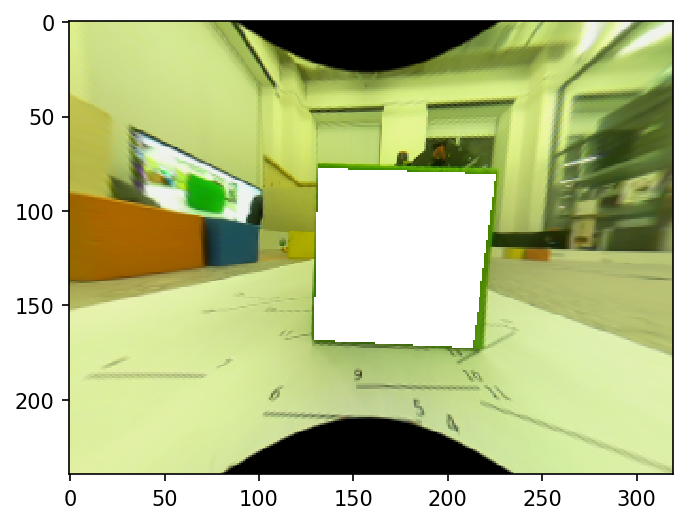

In [312]:
input_img = undisort_img.copy()
cv2.fillPoly(input_img, opt_params.reshape((2, 4)). T[np.newaxis, :, :], (255, 255, 255))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
plt.imshow(input_img, cmap="gray");